In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
# load the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CVAE(nn.Module):
    def __init__(
          self,
          x_dim,
          hidden_dim,
          z_dim,
          cond_dim
        ):
        super(CVAE, self).__init__()

        # Define autoencoding layers
        self.l_dim = z_dim
        self.enc_layer1 = nn.Linear(x_dim+cond_dim, hidden_dim)
        self.enc_layer2_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_layer2_logvar = nn.Linear(hidden_dim, z_dim)
        self.rec_loss = []
        self.rec_loss = []
        self.kl_div = []
        self.mse = []
        self.latent = torch.empty((64, 9), dtype=torch.int64)


        # Define autoencoding layers
        self.dec_layer1 = nn.Linear(z_dim + cond_dim, hidden_dim)
        self.dec_layer2 = nn.Linear(hidden_dim, x_dim)

    def encoder(self, x, y):
        # Now, both x and y should have the same number of rows, enabling concatenation along dim=1
        x = torch.cat((x, y), dim=1).to(device)
        x = F.relu(self.enc_layer1(x))
        mu = self.enc_layer2_mu(x)
        logvar = self.enc_layer2_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z, y):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #print(z.shape)
        self.latent = z
        z.to(device)
        y.to(device)
        z = torch.cat((z, y), dim=1).to(device)
        # Define decoder network
        output = F.relu(self.dec_layer1(z))
        output = F.relu(self.dec_layer2(output))
        return output

    def forward(self, x, y):
        y = y.view(-1, 1)  # -1 infers the number of rows based on the data, 1 column
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #print(type(z))
        output = self.decoder(z, y)
        return output, z, mu, logvar

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random nois
            z = torch.randn(num_samples, self.l_dim).to(device)
            # Pass the noise through the decoder to generate samples
            y = torch.tensor(y).float().to(device)
            y = y.unsqueeze(1)

            samples = self.decoder(z, y)
        # Return the generated samples
        return samples


In [ ]:


# Define the loss function
def loss_function(output, x, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss +  kl_loss) / mu.shape[0] , kl_loss / mu.shape[0] , recon_loss / mu.shape[0]


In [ ]:
def train_model(
    X,
    Y,
    latent_dim,
    learning_rate=1e-4,
    batch_size=64,
    num_epochs=400,
    hidden_dim=15,
  ):
    # Define the VAE model
  model = CVAE(x_dim=X.shape[1], hidden_dim=hidden_dim, z_dim=latent_dim, cond_dim=1)

  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
  # load the device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # Convert X & Y to a PyTorch tensor
  X = torch.tensor(X).float()
  X.to(device)
  Y = torch.tensor(Y).float()
  Y.to(device)

  # Create DataLoader object to generate minibatches
  dataset = TensorDataset(X, Y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  model.to(device)

  # Train the model
  for epoch in range(num_epochs):
      epoch_loss = 0
      kl_total = 0
      mse_total = 0
      for batch in dataloader:
          # Zero the gradients
          optimizer.zero_grad()

          # Get batch
          x = batch[0].to(device)
          y = batch[1].to(device)

          # Forward pass
          output, z, mu, logvar = model(x, y)

          # Calculate loss
          loss, kl, mse = loss_function(output, x, mu, logvar)

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          # Add batch loss to epoch loss
          epoch_loss += loss.item()
          kl_total += kl.item()
          mse_total += mse.item()



      model.rec_loss.append(epoch_loss /len(X))
      model.kl_div.append(kl_total /len(X))
      model.mse.append(mse_total /len(X))



      # Print epoch loss
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(X)}, KL: {kl_total/len(X)}, MSE: {mse_total/len(X)}")


  return model

In [ ]:
data_complete =  pd.read_csv("/content/Continuous_Pathway_I_VAE_dataset1.csv").drop('Unnamed: 0', axis=1)
flux = data_complete['Product_I']
features = data_complete.drop('Product_I', axis=1)
feat = features.values  # Convert data to numpy array
tar = flux.values

In [ ]:
latent = 11

In [ ]:
vae = train_model(feat, tar, latent)
print(vae)

Epoch 1/400, Loss: 0.4580312274932861, KL: 0.020665174114704133, MSE: 0.43736605377197263
Epoch 2/400, Loss: 0.42640238189697266, KL: 0.013128027319908142, MSE: 0.4132743537902832
Epoch 3/400, Loss: 0.3974196533203125, KL: 0.011177518510818482, MSE: 0.3862421340942383
Epoch 4/400, Loss: 0.3643964054107666, KL: 0.012805605792999268, MSE: 0.35159080085754396
Epoch 5/400, Loss: 0.3266790664672852, KL: 0.017578662943840025, MSE: 0.30910040435791014
Epoch 6/400, Loss: 0.2837600799560547, KL: 0.025046418976783752, MSE: 0.2587136615753174
Epoch 7/400, Loss: 0.23688277606964112, KL: 0.03382855908870697, MSE: 0.2030542158126831
Epoch 8/400, Loss: 0.2027478687286377, KL: 0.03957199325561524, MSE: 0.16317587471008302
Epoch 9/400, Loss: 0.17768733501434325, KL: 0.0398833966255188, MSE: 0.1378039388656616
Epoch 10/400, Loss: 0.1612413875579834, KL: 0.03859413862228393, MSE: 0.12264724826812744
Epoch 11/400, Loss: 0.14727209548950196, KL: 0.03651291527748108, MSE: 0.1107591796875
Epoch 12/400, Loss:

In [ ]:
from sklearn.decomposition import PCA

generated_samples = vae.sample(5000, tar)
generated_samples = generated_samples.cpu()
generated_samples = generated_samples.detach().numpy()

pca_real = PCA(n_components=latent)
real_result = pca_real.fit_transform(feat)

pca_synthetic = PCA(n_components=latent)
synthetic_result = pca_synthetic.fit_transform(generated_samples)

pca = PCA(n_components=latent, random_state=42)  # Choose the number of components for visualization
latent_2d = pca.fit_transform(vae.latent.cpu())

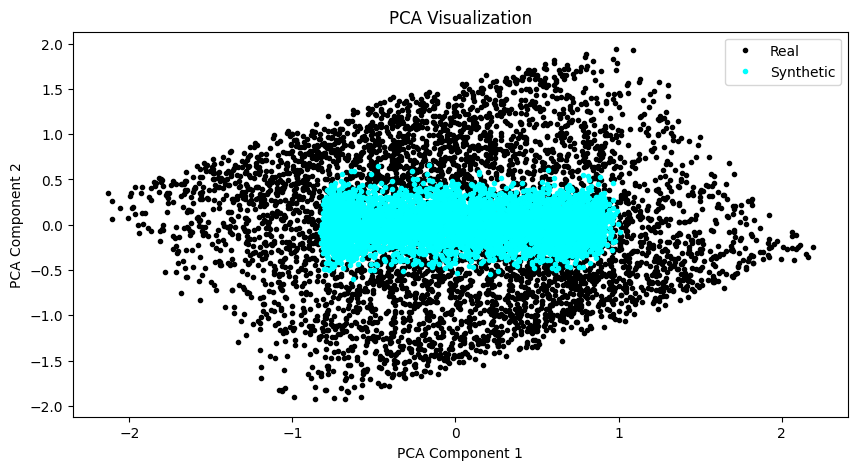

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

feature_1 = 0
feature_2 = 1

plt.figure(figsize=(10, 5))

plt.plot(real_result[:,feature_1], real_result[:, feature_2],".", color='black')
plt.plot(synthetic_result[:5000,feature_1], synthetic_result[:5000, feature_2],".", color='cyan')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')
plt.legend(['Real', 'Synthetic'])
plt.show()


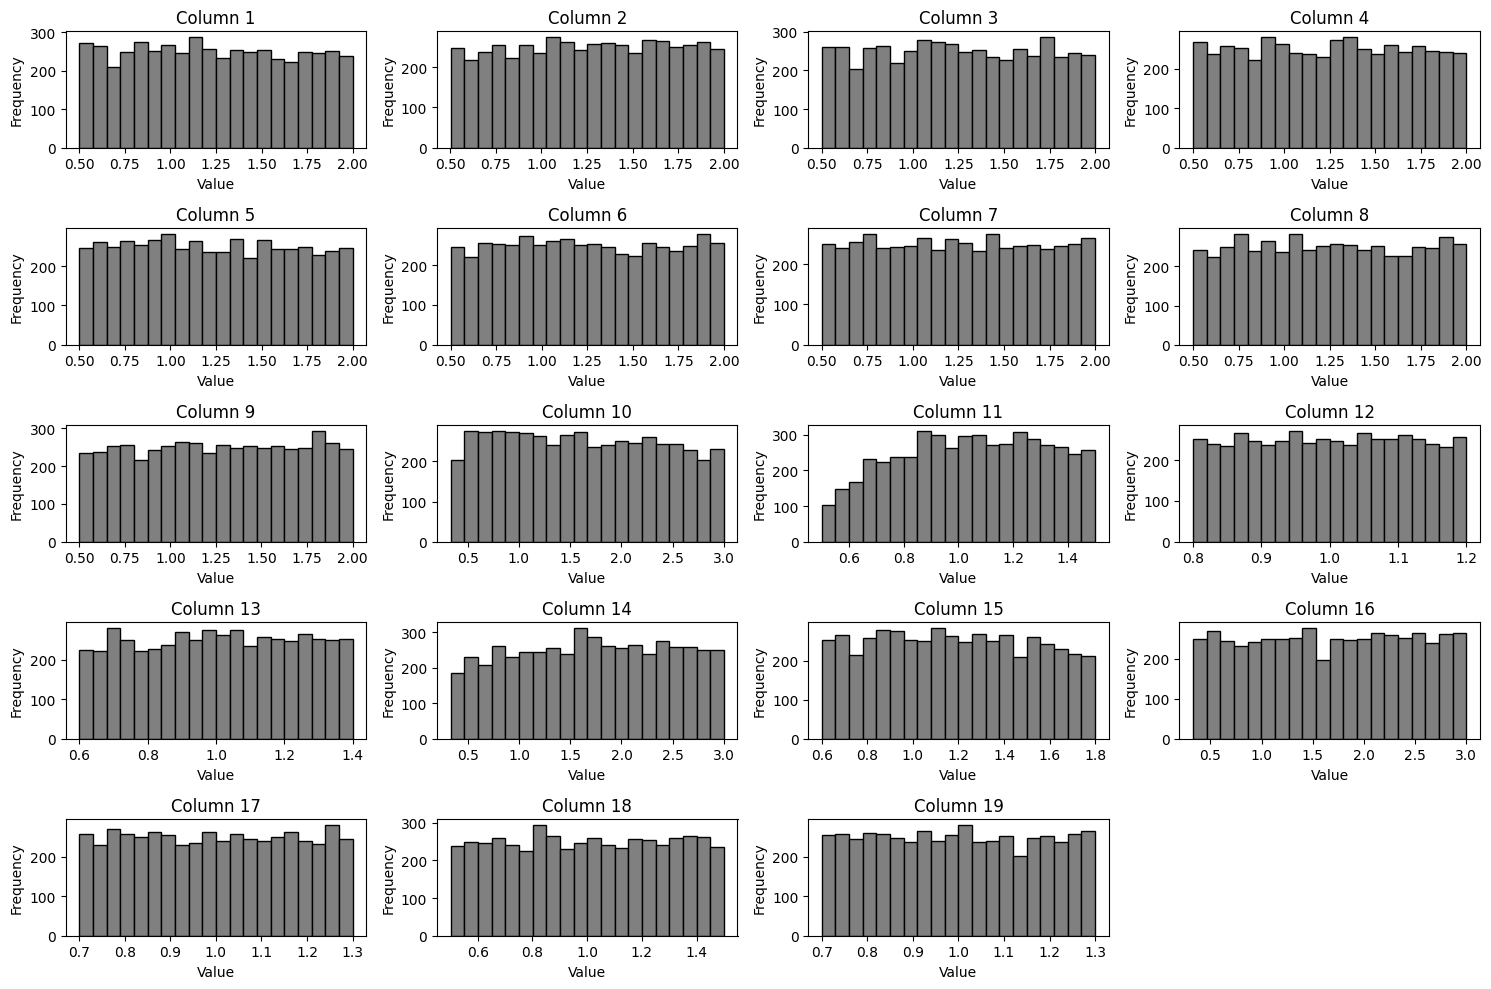

In [ ]:
# Sample data (replace this with your actual data)
data = feat

# Get the number of columns in the data
num_columns = data.shape[1]

# Calculate the number of rows and columns for the grid
num_rows = int(np.ceil(num_columns / 4))
num_cols = min(4, num_columns)

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each column
for i in range(num_columns):
    axes[i].hist(data[:, i], bins=20, color='grey', edgecolor='black')
    axes[i].set_title(f'Column {i + 1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots if the number of subplots is not a multiple of the grid size
for i in range(num_columns, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


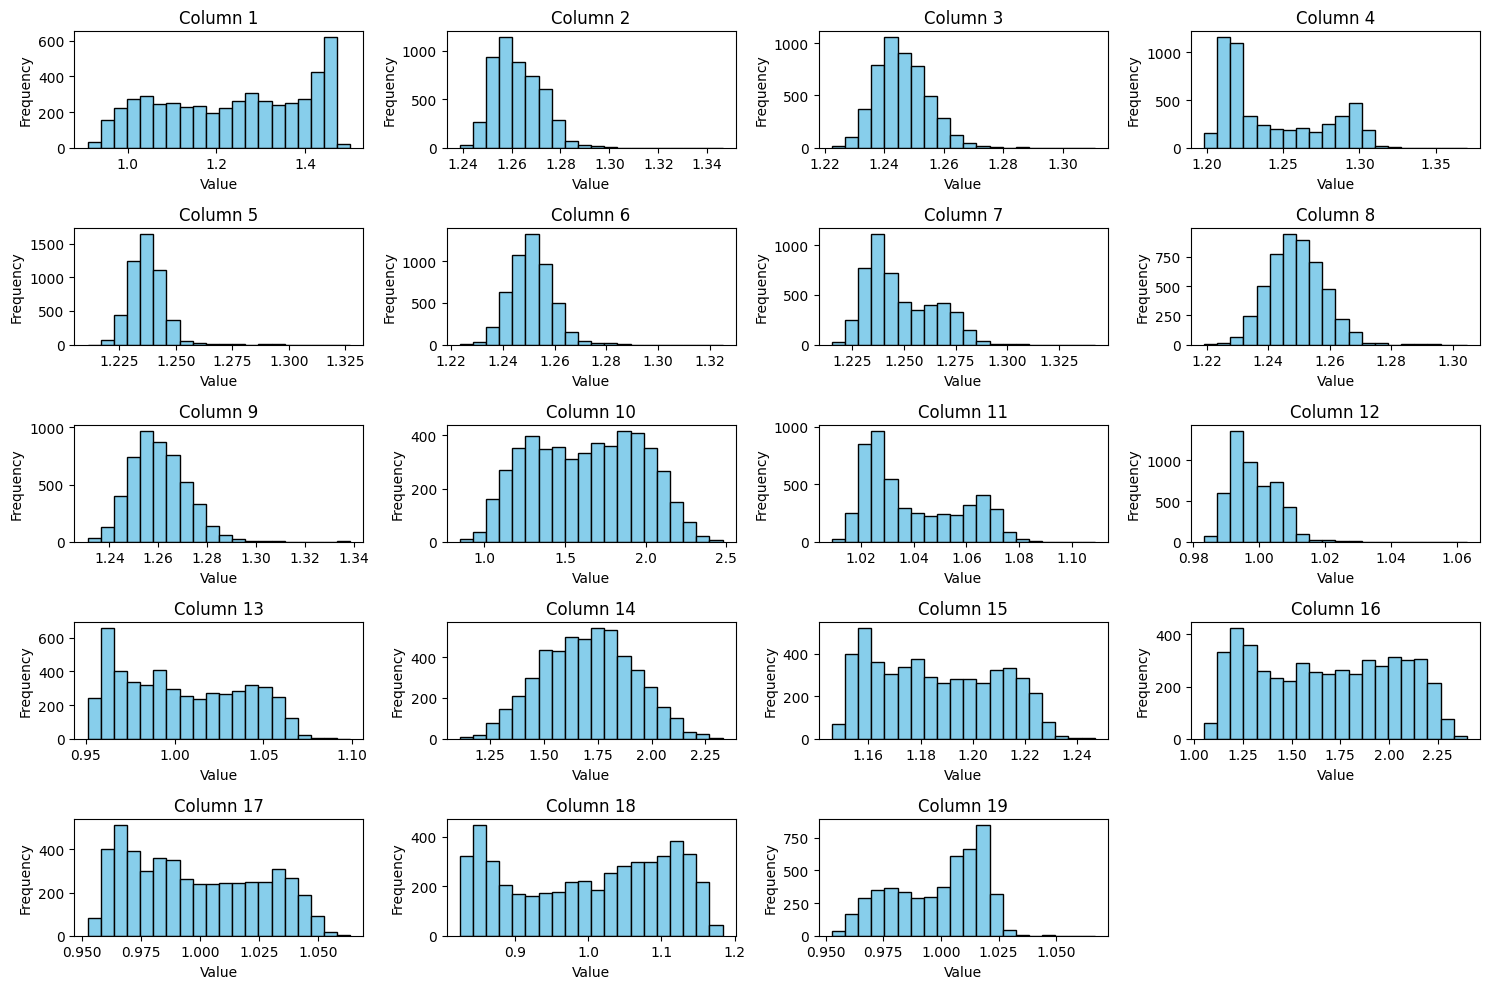

In [ ]:

# Sample data (replace this with your actual data)
data = generated_samples

# Get the number of columns in the data
num_columns = data.shape[1]

# Calculate the number of rows and columns for the grid
num_rows = int(np.ceil(num_columns / 4))
num_cols = min(4, num_columns)

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each column
for i in range(num_columns):
    axes[i].hist(data[:, i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Column {i + 1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots if the number of subplots is not a multiple of the grid size
for i in range(num_columns, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
feature_1 = 1
feature_2 = 2

# Determine the minimum and maximum values for the x and y axes in both datasets
x_min = min(real_result[:, feature_1].min(), synthetic_result[:, feature_1].min())
x_max = max(real_result[:, feature_1].max(), synthetic_result[:, feature_1].max())

y_min = min(real_result[:, feature_2].min(), synthetic_result[:, feature_2].min())
y_max = max(real_result[:, feature_2].max(), synthetic_result[:, feature_2].max())

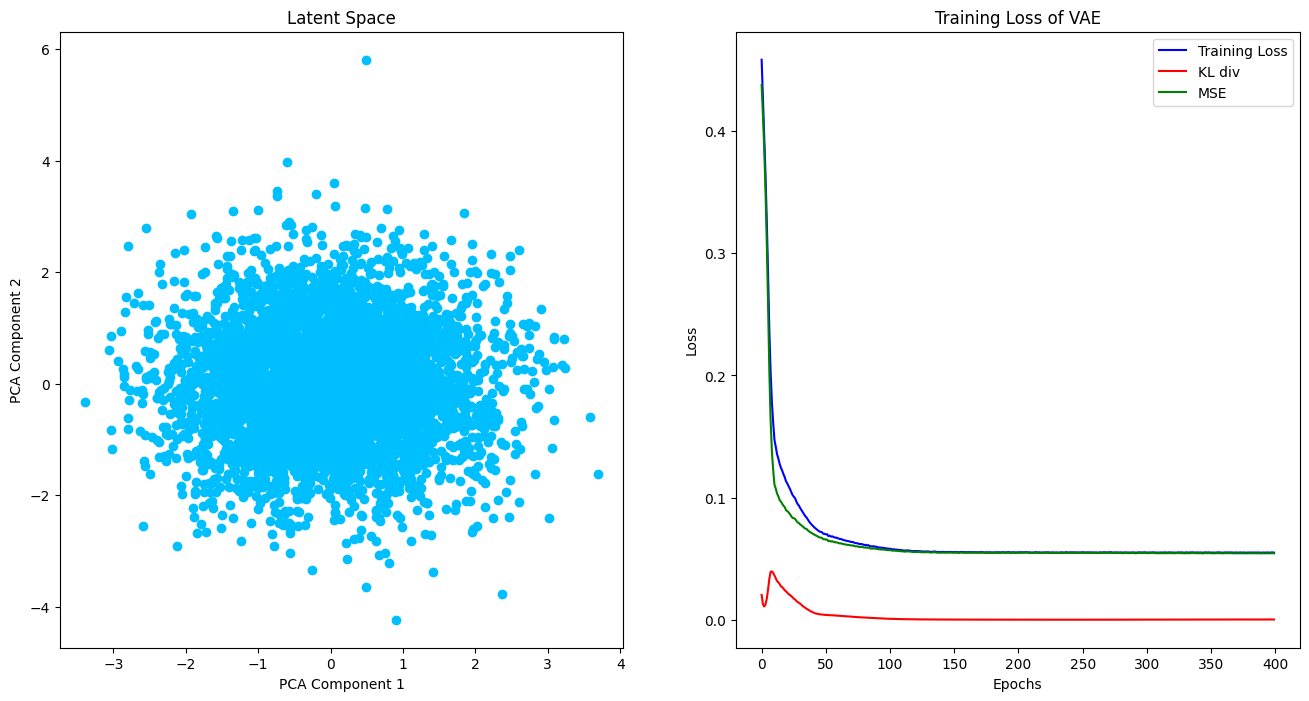

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(latent_2d[:, feature_1], latent_2d[:, feature_2],  c="deepskyblue")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title("Latent Space")

plt.subplot(1, 2, 2)

plt.plot(vae.rec_loss, label='Training Loss', c ="blue")
plt.plot(vae.kl_div, label='KL div', c="red")
plt.plot(vae.mse, label='MSE', c="green")

plt.title('Training Loss of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()



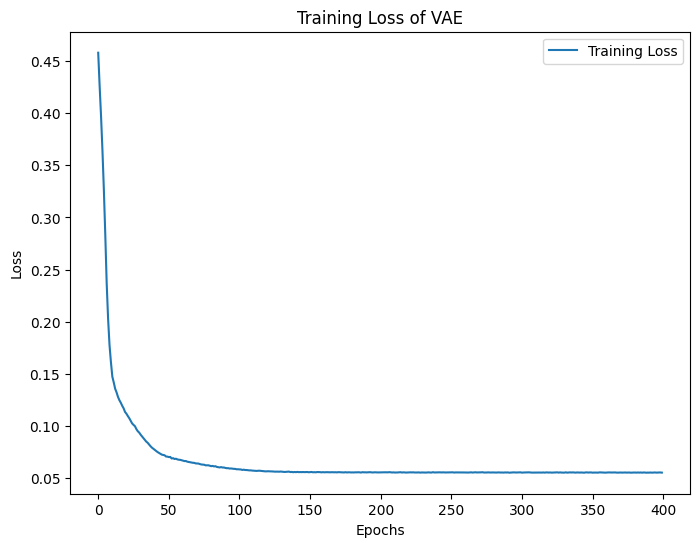

In [ ]:
# Assuming loss_values contains the stored loss values from training
plt.figure(figsize=(8, 6))
plt.plot(vae.rec_loss, label='Training Loss')
plt.title('Training Loss of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[0.020665174114704133, 0.013128027319908142, 0.011177518510818482, 0.012805605792999268, 0.017578662943840025, 0.025046418976783752, 0.03382855908870697, 0.03957199325561524, 0.0398833966255188, 0.03859413862228393, 0.03651291527748108, 0.03421164126396179, 0.032075361061096194, 0.030927802896499632, 0.02958939118385315, 0.027751547574996947, 0.027046458411216737, 0.025859730863571167, 0.024372744369506837, 0.02360128598213196, 0.022480948400497438, 0.021266152834892273, 0.02069829399585724, 0.019724883937835693, 0.01878241374492645, 0.01760347137451172, 0.016965116584300995, 0.01575720272064209, 0.015004699659347535, 0.014247238671779633, 0.013456330037117005, 0.012563719499111175, 0.01152431981563568, 0.010776786458492279, 0.010154540872573852, 0.009341117095947265, 0.008738138127326966, 0.008067887711524963, 0.007408549201488495, 0.006887083786725998, 0.006459176349639892, 0.005912067949771881, 0.005524814069271087, 0.00525156706571579, 0.0050642006278038025, 0.004860558041930199, 0

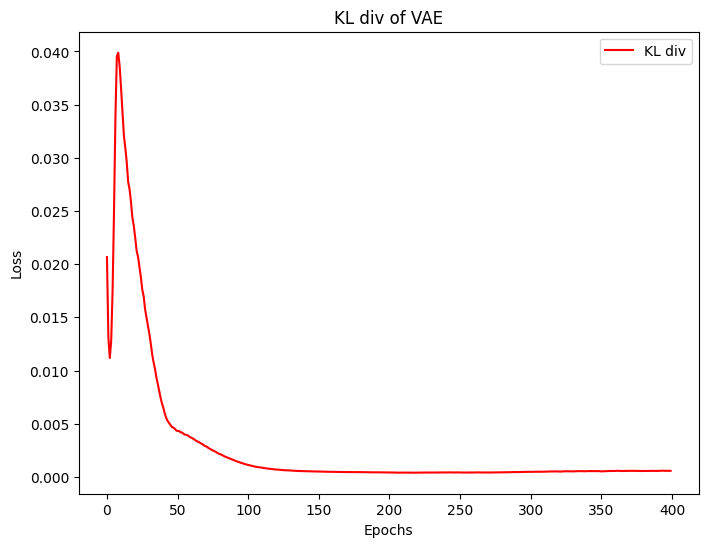

In [ ]:
print(vae.kl_div)

# Assuming loss_values contains the stored loss values from training
plt.figure(figsize=(8, 6))
plt.plot(np.array(vae.kl_div), label='KL div', c="red")
plt.title('KL div of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

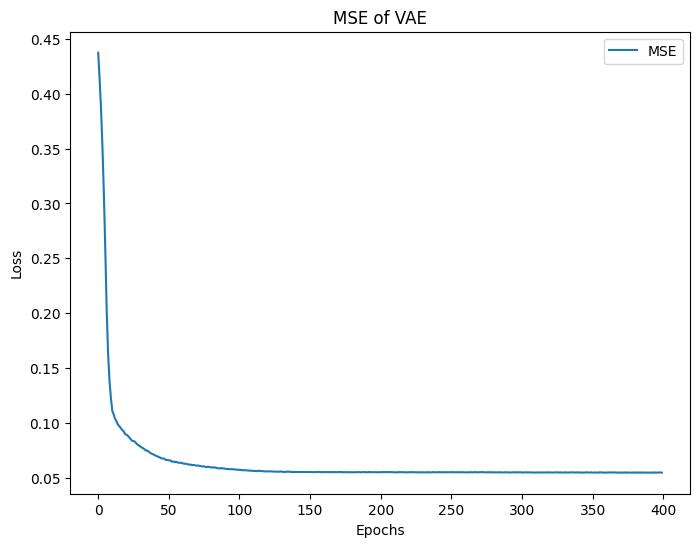

In [ ]:
# Assuming loss_values contains the stored loss values from training
plt.figure(figsize=(8, 6))
plt.plot(vae.mse, label='MSE')
plt.title('MSE of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()